## Esercizio 1

Sperimentare l'algoritmo `DBSCAN` con  i punti del file `walk.shp`. Inoltre modificare l'algoritmo in modo che elimini dal dataframe tutti i punti di ogni cluster tranne quello che è più vicino al centroide del cluster (vedere la documentazione della libreria shapely; potrebbe far comodo usare il tipo `MultiPoint` della suddetta libreria).

### Soluzione

In [1]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from os.path import join

def dbscan(punti_gdf, eps = 4, min_pts = 4):
    n = punti_gdf.shape[0]
    c = -1
    labels = ['None']*n
    
    for i, p in punti_gdf.iterrows():
        if labels[i] != 'None':
            continue
        
        N = punti_gdf[ punti_gdf.distance(p['geometry']) < eps ]
        
        if len(N) < min_pts:
            labels[i] = 'Noise'
            continue
    
        c += 1
        labels[i] = str(c)
        
        S = set(list(N.index)) - set([i])
        
        while len(S) > 0:
            q = S.pop()
            if labels[q] == 'Noise':
                labels[q] = str(c)
            if labels[q] != 'None':
                continue
            q_geom =  punti_gdf.loc[q, 'geometry']
            N = punti_gdf[ punti_gdf.distance(q_geom) < eps ]
            labels[q] = str(c)
            if len(N) < min_pts:
                continue
            S = S.union(set(list(N.index)) - set([q]))
            
    punti_gdf['label'] = labels
    
    return c+1 # numero di cluster

Numero di cluster: 6


<Axes: >

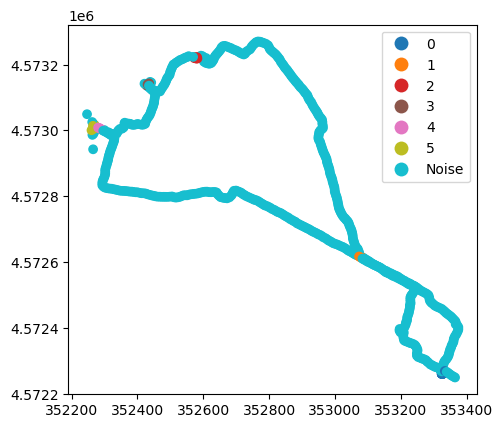

In [2]:
punti_gdf = gpd.read_file(join('data','walk.shp'))

num_cluster = dbscan(punti_gdf, 5, 4)

print('Numero di cluster:', num_cluster )

punti_gdf.plot('label', legend=True)

Per risolvere il problema:

1. filtrare dal geodataframe i punti di ogni cluster p.e. in questo modo  

In [ ]:
C2 = punti_gdf[ punti_gdf['label'] == '2' ]
C2

2. Inserire tutti i punti in un MultiPoint `mp`
3. Calcolare il centroide di `mp` con il metodi `centroid`
4. Trovare l'indice in `C2` del punto più vicino al centroide
5. Eliminare tutti gli altri punti di `C2` dal geodataframe di partenza

<Axes: >

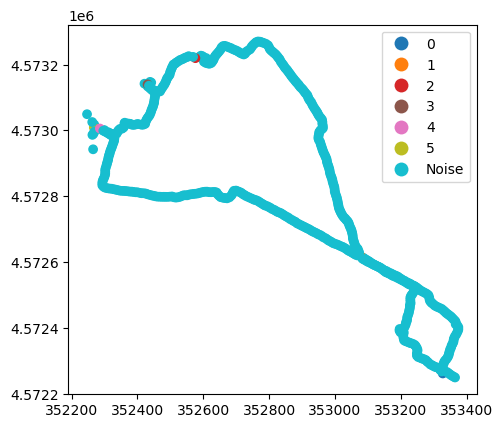

In [3]:
for c in range(num_cluster):
    C = punti_gdf[ punti_gdf['label'] == str(c) ]
    mp = MultiPoint( [p for p in C['geometry']] )
    c_mp = mp.centroid
    nearest_point, dist_min = None, None
    for i, p in C.iterrows():
        if dist_min == None or c_mp.distance(p['geometry']) < dist_min:
            nearest_point, dist_min = i, c_mp.distance(p['geometry'])
    for i in C.index:
        if i != nearest_point:
            punti_gdf.drop(i, inplace=True)

punti_gdf.plot('label', legend=True)

## Random datasets

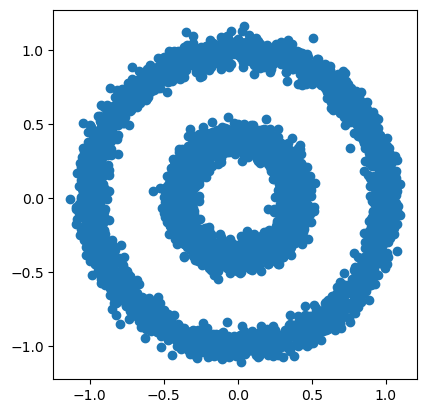

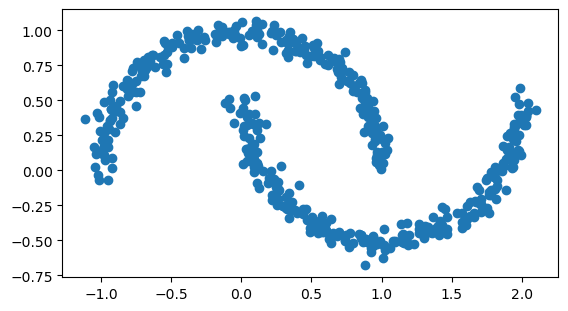

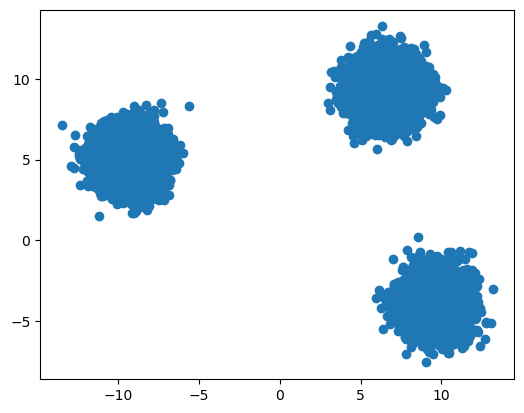

In [9]:
from sklearn import datasets

noisy_circles = datasets.make_circles(n_samples=5000, factor=0.4, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=500, noise=0.05)
blobs = datasets.make_blobs(n_samples=15000)

for the_dataset in (noisy_circles, noisy_moons, blobs): 

    punti = []
    for x, y in the_dataset[0]:
        punti.append(Point(x,y))

    punti_gdf = gpd.GeoDataFrame(geometry=punti)
    punti_gdf.plot()

Il GeoDataFrame `punti_gdf` è relativo al vettore `blobs` dell'ultima immagine. Si tratta di un GeoDataFrame di 15000 punti.

## Migliorare DBSCAN

Numero di cluster: 3
Total time: 0:04:35.611272


<Axes: >

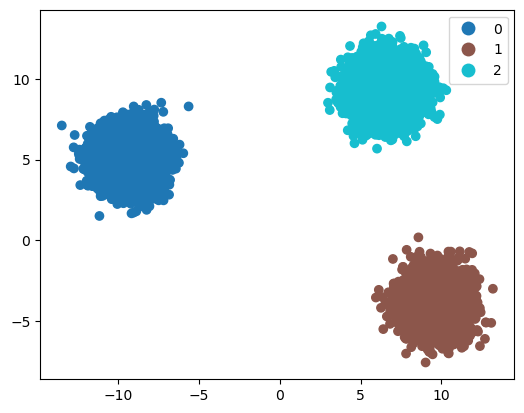

In [10]:
import datetime as dt

start_time = dt.datetime.now()
print('Numero di cluster:', dbscan(punti_gdf, 3, 4) )
finish_time = dt.datetime.now()                           
print('Total time: '+str( (finish_time - start_time)))

punti_gdf.plot('label', legend=True)

La parte più inefficiente dell'algoritmo è quella in cui vengono calcolati gli $\epsilon$-vicinati `N` che per ogni punto richiede `n` confronti.  Questa operazione può essere resa più veloce se i punti sono inseriti in un `KD-Tree` (`k`-dimensional tree).

### `KD-TREE`

Un `k`-dimensional tree è un albero binario in cui ogni nodo rappresenta una parte dello spazio; i figli di un nodo interno rappresentano, a loro volta, una suddivisione dello spazio rappresentato dal padre. Ogni foglia rappresenta uno spazio contenente un numero costante di punti. L'albero è bilanciato pertanto la sua altezza è $O(\log_2 n)$ dove $n$ è il numero di punti. La ricerca richiede il traversamento di un cammino dalla radice verso una foglia, pertanto richiede $O(\log_2 n)$ operazioni. Infine il costo per calcolare $N_{\epsilon}(p)$ è dato $O(m + \log_2 n)$ dove $m$ è il numero di punti in $N_{\epsilon}(p)$.

Useremo l'implementazione dei `KD-TREE` contenuta nella libreria `scikit-learn`

In [11]:
from sklearn.neighbors import KDTree

def dbscan(punti_gdf, eps = 4, min_pts = 4):
    n = punti_gdf.shape[0]
    c = -1
    labels = ['None']*n
    
    bt = KDTree( [p.coords[0] for p in punti_gdf['geometry']] ) # viene creato il kdtree usando i punti nella colonna geometry
    
    for i, p in punti_gdf.iterrows():
        if labels[i] != 'None':
            continue
        
        indices = bt.query_radius([p['geometry'].coords[0]], eps)[0] # ritorna gli indici punti a distanza al più eps dal punto in input.
                                                                    # sono gli stessi indici utilizzati nel geodataframe
        
        N = punti_gdf.iloc[ indices ]
        
        if len(N) < min_pts:
            labels[i] = 'Noise'
            continue
    
        c += 1
        labels[i] = str(c)
        
        S = set(list(N.index)) - set([i])
        
        while len(S) > 0:
            q = S.pop()
            if labels[q] == 'Noise':
                labels[q] = str(c)
            if labels[q] != 'None':
                continue
            q_geom =  punti_gdf.loc[q, 'geometry']
            
            indices = bt.query_radius([q_geom.coords[0]], eps)[0]
            N = punti_gdf.iloc[ indices ]
            
            labels[q] = str(c)
            if len(N) < min_pts:
                continue
            S = S.union(set(list(N.index)) - set([q]))
            
    punti_gdf['label'] = labels
    
    return c+1 # numero di cluster

Numero di cluster: 3
Total time: 0:00:29.767610


<Axes: >

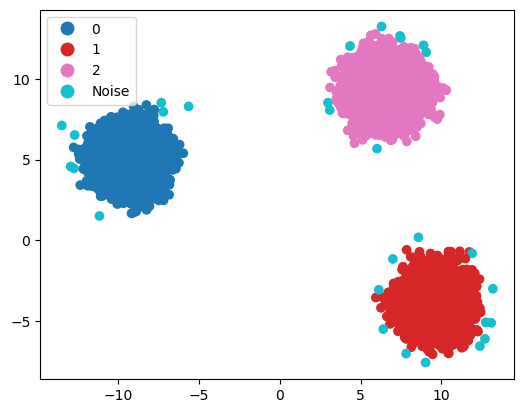

In [12]:
start_time = dt.datetime.now()
print('Numero di cluster:', dbscan(punti_gdf, 0.5, 4) )
finish_time = dt.datetime.now()                           
print('Total time: '+str( (finish_time - start_time)))

punti_gdf.plot('label', legend=True)

## `DBRS`: Algoritmo Density-Based Random Seeds

Proposto da [](https://www.researchgate.net/publication/220894536_DBRS_A_Density-Based_Spatial_Clustering_Method_with_Random_Sampling)

- *Osservazione*: ogni cluser è defiito da un insieme minimo di *core* points
- Trovare questo insieme è Np-hard
- Si procede ad una esemplificazione
    - si sceglie un punto $p$ a coso
    - trovato un core point $p$, tutti in punti in $N_{\epsilon}(p)$ sono considerati core
    - $N_{\epsilon}(p)$ viene fuso con tutti i precedenti cluster che hanno intersezione nun vuota con $N_{\epsilon}(p)$
    - i cluster trovati vengono mantenuti in una lista

In [14]:
def dbrs(punti_gdf, eps = 4, min_pts = 4):
    n = punti_gdf.shape[0]
    cluster_list = [] # lista di cluster, ogni cluster un set di indici
    unclassified = set(punti_gdf.index)
    labels = ['None']*n
    
    while len(unclassified) > 0:
        q = unclassified.pop() # meglio se random
        N = punti_gdf[punti_gdf.distance(punti_gdf.loc[q, 'geometry']) < eps]
        N_set = set(N.index)      # la struttura set serve per rendere efficienti le operazioni di intersezione e unione con gli altri clusete
        if len(N_set) < min_pts:
            labels[q] = 'Noise'
            continue
        for x in N.index:
            if x in unclassified:
                unclassified.remove(x)

        i, len_cluster_list = 0, len(cluster_list)
    
        while i < len_cluster_list:
            if len(N_set.intersection(cluster_list[i])) > 0: # viene creato un nuovo cluster dalla fusione di N con cluster_list[i]
                N_set = N_set.union(cluster_list[i])
                del(cluster_list[i])
                # cancellazione da lista, operazione costosa
                # meglio utilizzare lista concatenata
                len_cluster_list -= 1  
            else:
                i += 1
        cluster_list.append(N_set)
    
    # se q appartiene al cluster i, la sua etichetta sarà i
    for i in range(len(cluster_list)):
        while len(cluster_list[i]) > 0:
            q = cluster_list[i].pop()
            labels[q] = str(i)            
        
    punti_gdf['label'] = labels
    return len(cluster_list)

Mentre in `DBSCAN` veniva calcolato $N_{\epsilon}(q)$ per ogni punto $q$ raggiungibile dal punto corrente $p$, in `DBRS` questo non viene fatto in queto tutti i punti in $N_{\epsilon}(p)$ sono considerati core. Questo algoritmo può sbagliare nel caso in cui l'intersezione tra $N_{\epsilon}(p)$ ed un cluster già calcolato contenga solo punti di frontiera dei due insiemi. Per istanze sufficientemente fitte questa eventualità è remota.

Numero di cluster: 5
Total time: 0:00:03.707512


<Axes: >

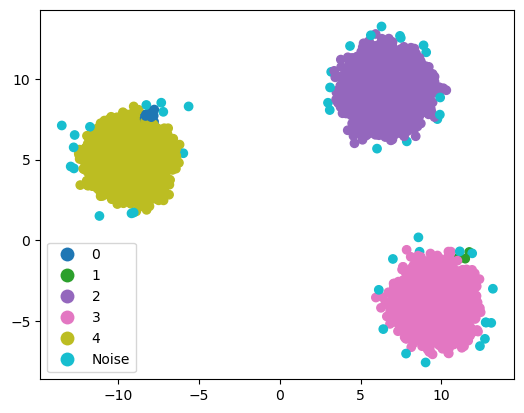

In [15]:
start_time = dt.datetime.now()
print('Numero di cluster:', dbrs(punti_gdf, 0.5, 4) )
finish_time = dt.datetime.now()                           
print('Total time: '+str( (finish_time - start_time)))

punti_gdf.plot('label', legend=True)